In [1]:
import math
import io
import shutil
import os
import sys
from os import path
import json

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
df = pd.read_csv(path.join('dataset', 'EVSE-B-HPC-Kernel-Events-processed.csv'))
df

,irq_softirq_exit,irq_softirq_entry,irq_softirq_raise,kmem_kmem_cache_free,kmem_kmem_cache_alloc,net_netif_rx,net_netif_rx_ni_exit,net_netif_rx_ni_entry,rpm_rpm_usage,rpm_rpm_resume,...,Scenario_DoS,Scenario_Recon,Label_attack,Label_benign,interface_any,interface_iso15118,interface_iso15118,interface_none,interface_ocpp,isDoS
0,5808,5808,5826,3976,4016,0,0,0,4277,4369,...,False,False,True,False,True,False,False,False,False,False
1,4791,4791,4808,12217,13581,0,0,0,1355,1391,...,False,False,True,False,True,False,False,False,False,False
2,6635,6635,6667,16222,16487,0,0,0,2683,2719,...,False,False,True,False,True,False,False,False,False,False
3,9165,9165,9228,15833,17867,0,0,0,4934,4988,...,False,False,True,False,True,False,False,False,False,False
4,8405,8405,8431,16182,15720,0,0,0,4736,4778,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6161,95032,95032,95043,109798,109887,44337,44335,44335,80240,80266,...,True,False,True,False,False,False,False,False,True,True
6162,96744,96744,96779,98202,98220,37797,37795,37795,69827,69873,...,True,False,True,False,False,False,False,False,True,True
6163,99936,99935,99947,105024,104998,41208,41208,41208,75511,75531,...,True,False,True,False,False,False,False,False,True,True
6164,96575,96576,96590,99527,99583,38825,38825,38825,71057,71074,...,True,False,True,False,False,False,False,False,True,True


In [7]:
# min-max normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df_normalized = pd.DataFrame(normalized_data, columns=df.columns)
df_normalized

,irq_softirq_exit,irq_softirq_entry,irq_softirq_raise,kmem_kmem_cache_free,kmem_kmem_cache_alloc,net_netif_rx,net_netif_rx_ni_exit,net_netif_rx_ni_entry,rpm_rpm_usage,rpm_rpm_resume,...,Scenario_DoS,Scenario_Recon,Label_attack,Label_benign,interface_any,interface_iso15118,interface_iso15118,interface_none,interface_ocpp,isDoS
0,0.047937,0.047935,0.048078,0.010061,0.010228,0.000000,0.000000,0.000000,0.042511,0.043414,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.039543,0.039541,0.039677,0.030916,0.034589,0.000000,0.000000,0.000000,0.013468,0.013822,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.054762,0.054760,0.055019,0.041051,0.041990,0.000000,0.000000,0.000000,0.026667,0.027018,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.075644,0.075641,0.076153,0.040066,0.045505,0.000000,0.000000,0.000000,0.049041,0.049565,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.069371,0.069369,0.069576,0.040949,0.040037,0.000000,0.000000,0.000000,0.047073,0.047478,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6161,0.784351,0.784325,0.784332,0.277850,0.279868,0.706026,0.706005,0.705994,0.797535,0.797587,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6162,0.798481,0.798455,0.798658,0.248506,0.250153,0.601882,0.601860,0.601850,0.694036,0.694314,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6163,0.824827,0.824791,0.824802,0.265769,0.267416,0.656199,0.656210,0.656199,0.750532,0.750537,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6164,0.797086,0.797068,0.797098,0.251859,0.253625,0.618252,0.618262,0.618252,0.706262,0.706248,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [27]:
# data splitting: training and testing
from sklearn.model_selection import train_test_split

# Separate features and labels
X = df_normalized.iloc[:, :-1].values  # All columns except the last one
y = df_normalized.iloc[:, -1].values   # The last column (label)

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(1)

# If the labels are for classification, ensure they're of `long` dtype
# y_train_tensor = y_train_tensor.long()
# y_test_tensor = y_test_tensor.long()

In [28]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([4932, 1, 41])
torch.Size([1234, 1, 41])
torch.Size([4932, 1])
torch.Size([1234, 1])


In [25]:
# define model, loss function, optimizer
class TransformerBinaryClassifier(nn.Module):
    def __init__(self, d_model, nhead, num_layers):
        super(TransformerBinaryClassifier, self).__init__()

        # Transformer Encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            activation='relu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected layers for binary classification
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),  # Reduce to half
            nn.ReLU(),
            nn.Linear(d_model // 2, 1),        # Output 1 value for binary classification
            nn.Sigmoid()                      # Sigmoid for binary classification
        )

    def forward(self, x):
        """
        x: Input tensor of shape (batch_size, seq_len, d_model)
           For a series of length 1, seq_len=1.
        """
        # Ensure input has shape (seq_len, batch_size, d_model) for Transformer
        x = x.permute(1, 0, 2)

        # Transformer Encoder
        encoded = self.transformer_encoder(x)  # Shape: (seq_len, batch_size, d_model)

        # For a single timestep, seq_len=1, so take the output directly
        cls_token_embedding = encoded[0]  # Shape: (batch_size, d_model)

        # Pass through the classification head
        output = self.fc(cls_token_embedding)  # Shape: (batch_size, 1)

        return output

# # Define model parameters
# d_model = 41
# nhead = 1
# num_layers = 2

# # Create model instance
# model = TransformerBinaryClassifier(d_model, nhead, num_layers)

# # Dummy input: (batch_size=16, seq_len=1, d_model=128)
# x = torch.rand(16, 1, d_model)

# # Forward pass
# output = model(x)
# print(output.shape)  # Output shape: (16, 1)

# # training pipeline + evaluation + curve plotting


D:\Projects\CondaEnvs\ensc897\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/50: Train Loss = 0.5233, Validation Loss = 0.3601
Epoch 1/50:
  Train Loss = 0.5233
  Validation Loss = 0.3601
  Validation Accuracy = 0.9887, Precision = 1.0000, Recall = 0.9152
Epoch 2/50: Train Loss = 0.3280, Validation Loss = 0.2777
Epoch 2/50:
  Train Loss = 0.3280
  Validation Loss = 0.2777
  Validation Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000
Epoch 3/50: Train Loss = 0.2675, Validation Loss = 0.2334
Epoch 3/50:
  Train Loss = 0.2675
  Validation Loss = 0.2334
  Validation Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000
Epoch 4/50: Train Loss = 0.2276, Validation Loss = 0.2001
Epoch 4/50:
  Train Loss = 0.2276
  Validation Loss = 0.2001
  Validation Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000
Epoch 5/50: Train Loss = 0.1961, Validation Loss = 0.1728
Epoch 5/50:
  Train Loss = 0.1961
  Validation Loss = 0.1728
  Validation Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000
Epoch 6/50: Train Loss = 0.1695, Validation Loss = 0.1490
Epoch 6

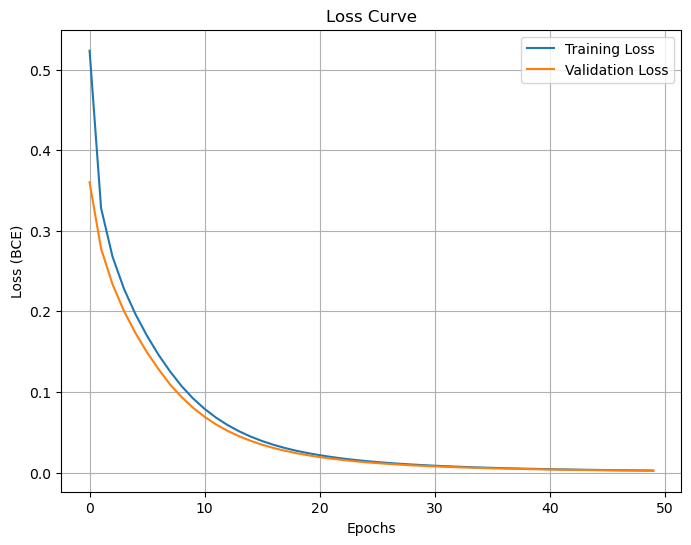

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Example parameters (adjust these for your use case)
d_model = 41
nhead = 1
num_layers = 2
batch_size = 128
epochs = 50
patience = 2  # Early stopping patience

# Define the model
model = TransformerBinaryClassifier(d_model, nhead, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Create DataLoaders for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training pipeline with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize lists to store loss values
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            # Convert predictions to binary (threshold = 0.5)
            preds = (outputs > 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)  # Handle division by zero
    recall = recall_score(all_labels, all_preds, zero_division=0)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss = {train_loss:.4f}")
    print(f"  Validation Loss = {val_loss:.4f}")
    print(f"  Validation Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1

    # Early stopping condition
    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Load the best model after training
model.load_state_dict(torch.load("best_model.pth"))
print("Training complete. Best model loaded.")

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (BCE)')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.savefig('loss_curve.png')
plt.show()